In [18]:
import pandas as pd
import sqlite3 as sq
import numpy as np
import surprise

## Import data from wrangled (limited db) and add sentiment analysis (DO NOT RUN THESE IF LOADING AFTER SENTIMENT)

In [ ]:
#Import data from original wrangled database
path = '/db/wrangled_reviews.db'
def import_data(db_path):
    conn = sq.connect(db_path) #sqliteDB path goes in parantheses
    crsr = conn.cursor()

    df = pd.read_sql_query('''
                SELECT *
                FROM trunc_books
                ;
                ''', conn)

    df['star_rating'] = df['star_rating'].astype(float)
    df['star_rating'] = df['star_rating'].astype(int) #convert rating to integer type
    df['helpful_votes'] = df['helpful_votes'].astype(int) #convert rating to integer type

    df['review_body'] = df['review_body'].astype(str) #convert to str
    df['review_headline'] = df['review_headline'].astype(str) #convert to str
    

    return df

df = import_data(path)

In [ ]:
df.head(5)
#len(df)
#df.dtypes

In [ ]:
def count_words(data):
   words = data.split(" ")
   num_words = len(words)
   return num_words

df['review_word_count']=0
df['review_hl_count']=0

df['review_word_count'] = df['review_body'].map(count_words)
df['review_hl_count'] = df['review_headline'].map(count_words)


Add in Sentiment Analysis

In [ ]:
from textblob import TextBlob
from numpy import interp

In [ ]:
def sentiment(row):
    try:
        #raw text of review
        blob = TextBlob(row['review_body'])
        #sentiment polarity score
        polarity = blob.sentiment.polarity
        score = interp(polarity, [-1,1], [1,5])
        return score
    except:
        pass

In [ ]:
def clean_sentiment(row):
    try:
        import string
        from nltk.corpus import stopwords

        #split raw text of review into tokens
        words= row['review_body']
        tokens = words.split()

        # remove punctuation from each token
        table = str.maketrans('', '', string.punctuation)
        tokens = [w.translate(table) for w in tokens]

        #remove tokens that are not alphabetic
        tokens = [word for word in tokens if word.isalpha()]

        # filter out stop words
        stop_words = set(stopwords.words('english'))
        tokens = [w for w in tokens if not w in stop_words]

        #convert this list to a string
        blob = ' '.join(tokens)

        #find sentiment of new string and convert to 1-5 scale
        blob = TextBlob(blob)
        polarity = blob.sentiment.polarity
        score = interp(polarity, [-1,1], [1,5])
        return score
    except:
        pass

In [ ]:
df['sentiment_star_rating'] = df.apply(sentiment,axis=1)
df['cleaned_sentiment_star_rating'] = df.apply(clean_sentiment,axis=1)
df['star_rating']=df['star_rating'].astype(float)
df['difference'] = abs(df['star_rating'] - df['cleaned_sentiment_star_rating'])


In [ ]:
conn = sq.connect(path)
df.to_sql('processed', conn, if_exists='append')


## Import data from processed database


In [2]:
#Set up data
path = '/db/wrangled_reviews.db'
def import_data(db_path):
    conn = sq.connect(db_path) #sqliteDB path goes in parantheses
    crsr = conn.cursor()

    df = pd.read_sql_query('''
                SELECT *
                FROM processed
                ;
                ''', conn)

    df['star_rating'] = df['star_rating'].astype(float)
    df['star_rating'] = df['star_rating'].astype(int) #convert rating to integer type
    df['helpful_votes'] = df['helpful_votes'].astype(int) #convert rating to integer type

    df['review_body'] = df['review_body'].astype(str) #convert to str
    df['review_headline'] = df['review_headline'].astype(str) #convert to str
    

    return df

df = import_data(path)

In [3]:
df.head(5)

,index,customer_id,product_id,product_title,product_parent,star_rating,helpful_votes,review_headline,review_body,product_category,marketplace,review_date,verified_purchase,review_word_count,review_hl_count,sentiment_star_rating,cleaned_sentiment_star_rating,difference
0,0,40676812,1938067126,Crimes of the Educators: How Utopians Are Usin...,402004849,5,0,Five Stars,Excellent--,Books,US,2015-08-31,Y,1,2,5.000000,5.000000,0.000000
1,1,2784618,014017737X,The Pearl,779170984,5,0,Five Stars,"Arrived before estimated delivery date, just a...",Books,US,2015-08-31,Y,8,2,3.000000,3.000000,2.000000
2,2,2876528,0982207743,Primal Blueprint Quick and Easy Meals: Delicio...,225126623,3,1,Three Stars,"Recipes are not complicated, but ingredients a...",Books,US,2015-08-31,Y,10,2,3.500000,2.000000,1.000000
3,3,33678379,080072433X,Trial Run (Fault Lines),42136245,3,0,Hard to Get Into,This book I actually had a hard time with. I p...,Books,US,2015-08-31,N,277,4,3.076869,3.009420,0.009420
4,4,32159651,0615815650,Methods of Persuasion: How to Use Psychology t...,625464646,3,1,Run of the mill,I've read quite a few books about persuasion p...,Books,US,2015-08-31,Y,22,4,2.624242,2.636364,0.363636


In [4]:
len(df)

388380

In [8]:
X_dat = df[['product_parent','star_rating','helpful_votes','review_word_count','review_hl_count','sentiment_star_rating', 'cleaned_sentiment_star_rating', 'difference']]



# YellowBrick Viz


In [ ]:
df.

In [9]:
from sklearn import datasets
from yellowbrick.target import FeatureCorrelation

# Load the regression data set
X, y = data['product_parent','helpful_votes','review_word_count','review_hl_count','sentiment_star_rating']
, data['star_rating']
feature_names = np.array(df['feature_names'])

visualizer = FeatureCorrelation(labels=feature_names)
visualizer.fit(X, y)
visualizer.poof()

ImportError: No module named 'yellowbrick.target'

/home/ubuntu/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


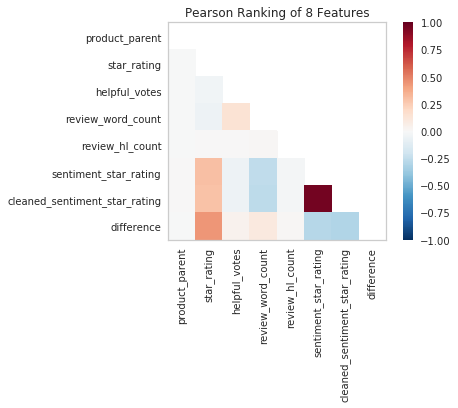

In [16]:
from yellowbrick.features import Rank2D
%matplotlib inline

visualizer = Rank2D(algorithm="pearson")
visualizer.fit_transform(X_dat)
visualizer.poof()

/home/ubuntu/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


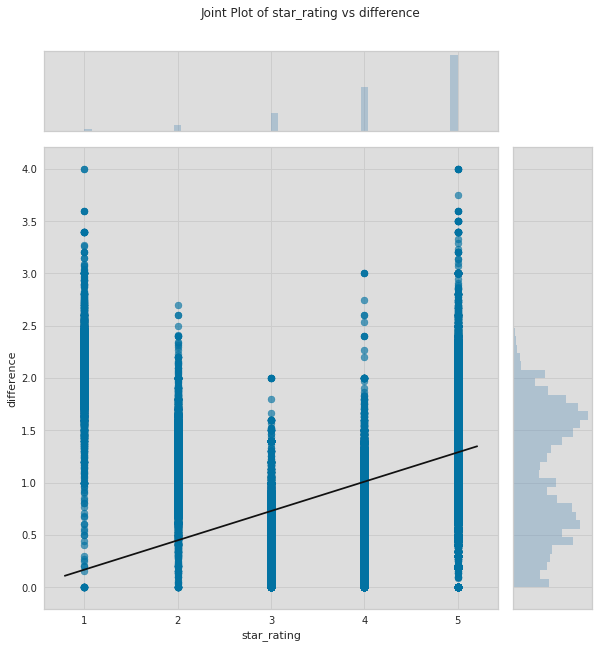

In [11]:
from yellowbrick.features import JointPlotVisualizer

visualizer = JointPlotVisualizer(feature='star_rating', target='difference')
visualizer.fit(X_dat['star_rating'], X_dat['difference'])
visualizer.poof()

/home/ubuntu/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


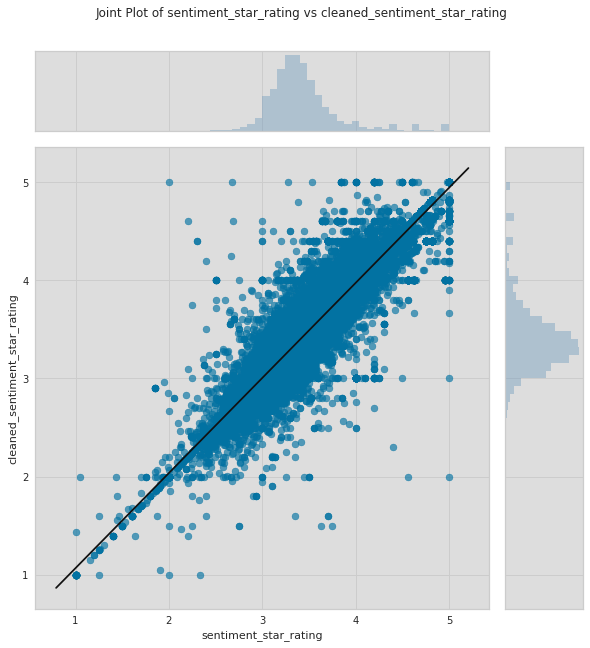

In [12]:
from yellowbrick.features import JointPlotVisualizer

visualizer = JointPlotVisualizer(feature='sentiment_star_rating', target='cleaned_sentiment_star_rating')
visualizer.fit(X_dat['sentiment_star_rating'], X_dat['cleaned_sentiment_star_rating'])
visualizer.poof()

/home/ubuntu/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


array([[ 1.        ,  0.29815656],
       [ 0.29815656,  1.        ]])

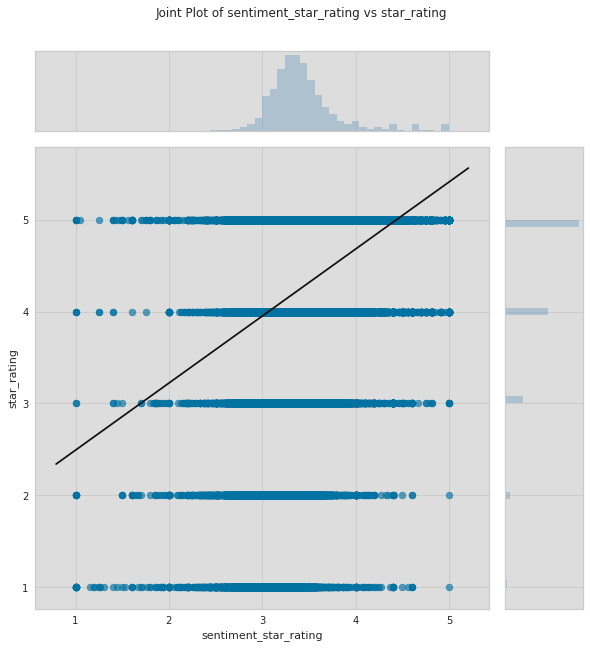

In [19]:
from yellowbrick.features import JointPlotVisualizer

visualizer = JointPlotVisualizer(feature='sentiment_star_rating', target='star_rating')
visualizer.fit(X_dat['sentiment_star_rating'], X_dat['star_rating'])
visualizer.poof()

np.corrcoef(X_dat['sentiment_star_rating'], X_dat['star_rating'])


/home/ubuntu/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


array([[ 1.        ,  0.29543988],
       [ 0.29543988,  1.        ]])

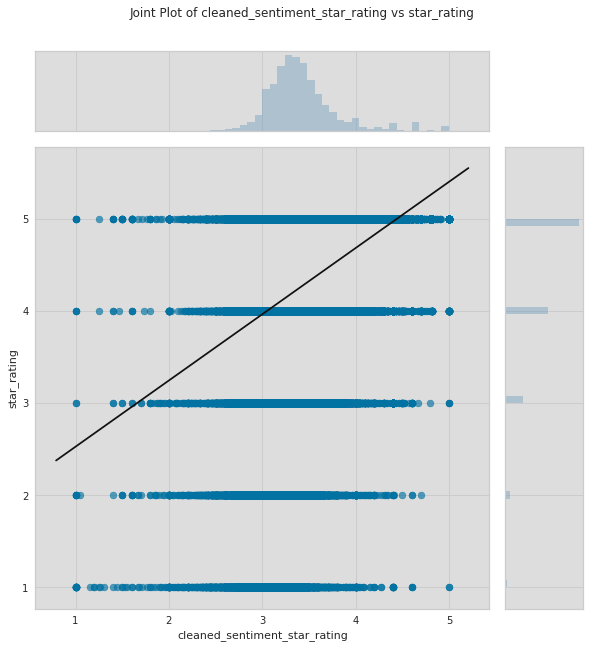

In [21]:
from yellowbrick.features import JointPlotVisualizer

visualizer = JointPlotVisualizer(feature='cleaned_sentiment_star_rating', target='star_rating')
visualizer.fit(X_dat['cleaned_sentiment_star_rating'], X_dat['star_rating'])
visualizer.poof()

np.corrcoef(X_dat['cleaned_sentiment_star_rating'], X_dat['star_rating'])


/home/ubuntu/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


array([[ 1.       ,  0.4408545],
       [ 0.4408545,  1.       ]])

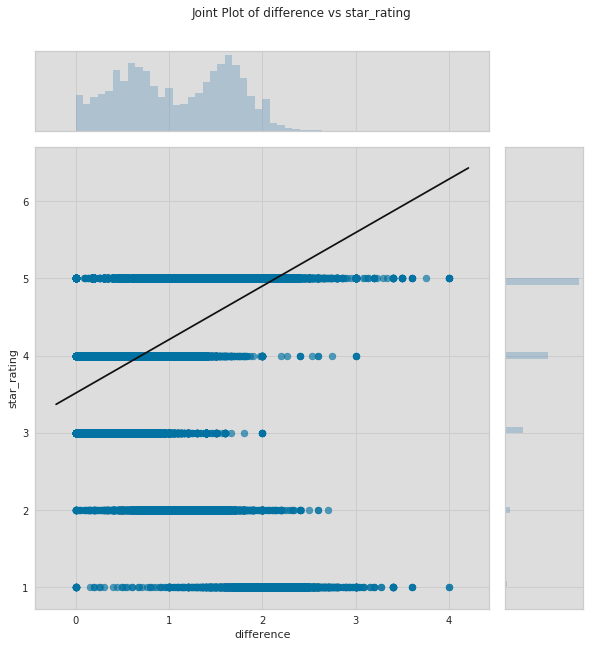

In [25]:
from yellowbrick.features import JointPlotVisualizer

visualizer = JointPlotVisualizer(feature='difference', target='star_rating')
visualizer.fit(X_dat['difference'], X_dat['star_rating'])
visualizer.poof()

np.corrcoef(X_dat['difference'], X_dat['star_rating'])

## Clustering

In [ ]:
from sklearn.cluster import MiniBatchKMeans

from yellowbrick.cluster import KElbowVisualizer

# Instantiate the clustering model and visualizer
visualizer = KElbowVisualizer(MiniBatchKMeans(), k=(4,12))

visualizer.fit(X_dat) # Fit the training data to the visualizer
visualizer.poof() # Draw/show/poof the data

In [ ]:
from sklearn.cluster import MiniBatchKMeans

from yellowbrick.cluster import SilhouetteVisualizer

# Instantiate the clustering model and visualizer
model = MiniBatchKMeans(7)
visualizer = SilhouetteVisualizer(model)

visualizer.fit(X_dat) # Fit the training data to the visualizer
visualizer.poof() # Draw/show/poof the data

# Modeling in Sci-Kit Learn

In [28]:
from scipy.sparse import csr_matrix
df_pivot = df.pivot_table(index='customer_id',columns='product_title',values='star_rating',fill_value=0)
X = df_pivot.T

MemoryError: 

In [29]:
from sklearn.decomposition import TruncatedSVD
SVD = TruncatedSVD(n_components=12, random_state=17)
matrix = SVD.fit_transform(X)
matrix.shape

MemoryError: 

In [24]:
import numpy as np
corr = np.corrcoef(matrix)
corr.shape

(30854, 30854)

In [ ]:
book_title=

# Modeling in Suprise

In [ ]:
from surprise import Reader, Dataset

# to load dataset from pandas df, we need `load_fromm_df` method in surprise lib

ratings_dict = {'itemID': list(df.product_id),
                'userID': list(df.customer_id),
                'rating': list(df.star_rating)}
df = pd.DataFrame(ratings_dict)

# A reader is still needed but only the rating_scale param is required.
# The Reader class is used to parse a file containing ratings.
reader = Reader(rating_scale=(1, 5))

# The columns must correspond to user id, item id and ratings (in that order).
data = Dataset.load_from_df(df[['userID', 'itemID', 'rating']], reader)


In [ ]:
###Using Suprise package
# Split data into 5 folds

data.split(n_folds=5)

from surprise import SVD, evaluate
from surprise import NMF, model_selection

# svd
algo = SVD()
model_selection.cross_validate(algo, data, measures=['RMSE'])




In [ ]:
# nmf
algo = NMF()
nmf_mod = model_selection.cross_validate(algo, data, measures=['RMSE'])
nmf_mod.fit()

In [ ]:
def recommend_movies(predictions, userID, movies, original_ratings, num_recommendations):
    
    # Get and sort the user's predictions
    user_row_number = userID - 1 # User ID starts at 1, not 0
    sorted_user_predictions = preds.iloc[user_row_number].sort_values(ascending=False) # User ID starts at 1
    
    # Get the user's data and merge in the movie information.
    user_data = original_ratings[original_ratings.user_id == (userID)]
    user_full = (user_data.merge(movies, how = 'left', left_on = 'movie_id', right_on = 'movie_id').
                     sort_values(['rating'], ascending=False)
                 )
    
    # Recommend the highest predicted rating movies that the user hasn't seen yet.
    recommendations = (movies[~movies['movie_id'].isin(user_full['movie_id'])].
         merge(pd.DataFrame(sorted_user_predictions).reset_index(), how = 'left',
               left_on = 'movie_id',
               right_on = 'movie_id').
         rename(columns = {user_row_number: 'Predictions'}).
         sort_values('Predictions', ascending = False).
                       iloc[:num_recommendations, :-1]
                      )

    return user_full, recommendations